# TODO: 
# - delete all unused datasets

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import myutils as myu
import folium
from folium.features import DivIcon

### Read AirBnB data of Munich, Germany
##### Time period: 15.03.2019 + 1 year in the future (calendar)

Problem of the dataset is the timeperiod

In [2]:
munich_listings_raw = pd.read_csv("./data/munich/listings.csv.gz", low_memory=False) 

In [ ]:
#munich_calendar_raw = pd.read_csv("./data/munich/calendar.csv.gz")

In [ ]:
#munich_reviews_raw = pd.read_csv("./data/munich/reviews.csv.gz")

## 1. Price prediction 
Predict the price with an Linear Regression Model with the data from the listing. Discover which of the following factors influce the price the most
- location = neighbourhood + latitude + longitude
- room-type = room_type
- rating
- host - super-host and identified
- instant bookable

### 1.1 Dataset preparation

In [6]:
# define all necessary categories
categories = ["id",
              "price",
              "neighbourhood_cleansed",
              "latitude",
              "longitude", 
              "review_scores_value",
              "review_scores_rating", 
              "number_of_reviews",
              "room_type", 
              "host_identity_verified",
              "host_is_superhost", 
              "instant_bookable" ]
# create dataset only with necessary variables/categories
munich_listings = munich_listings_raw[categories]
munich_listings.rename({"neighbourhood_cleansed": "neighbourhood"}, axis="columns", inplace=True)
munich_listungs.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,id,price,neighbourhood,latitude,longitude,review_scores_value,review_scores_rating,number_of_reviews,room_type,host_identity_verified,host_is_superhost,instant_bookable
0,36720,$95.00,Ludwigsvorstadt-Isarvorstadt,48.13057,11.56929,9.0,98.0,25,Entire home/apt,f,f,f
1,97945,$80.00,Hadern,48.11476,11.48782,9.0,97.0,115,Entire home/apt,f,t,f
2,114695,$95.00,Berg am Laim,48.11923,11.63726,9.0,95.0,47,Entire home/apt,t,f,f
3,127383,$120.00,Maxvorstadt,48.15198,11.56486,10.0,97.0,75,Entire home/apt,t,t,f
4,159634,$55.00,Pasing-Obermenzing,48.13898,11.46612,9.0,93.0,27,Entire home/apt,t,f,t


In [7]:
munich_listings.dtypes

id                          int64
price                      object
neighbourhood              object
latitude                  float64
longitude                 float64
review_scores_value       float64
review_scores_rating      float64
number_of_reviews           int64
room_type                  object
host_identity_verified     object
host_is_superhost          object
instant_bookable           object
dtype: object

In [9]:
# convert price from object to float
munich_listings[["price"]] = munich_listings[["price"]].replace("[\$,]", "", regex=True).astype(float)

### 1.2 Check for missing values

In [10]:
categories_w_mising_values = myu.find_categories_w_missing_values(munich_listings)

No missing values in id
No missing values in price
No missing values in neighbourhood
No missing values in latitude
No missing values in longitude
Missing values in review_scores_value
Missing values in review_scores_rating
No missing values in number_of_reviews
No missing values in room_type
Missing values in host_identity_verified
Missing values in host_is_superhost
No missing values in instant_bookable

There are 4 categories with missing values


### 1.3 Dealing with missing values
#### occurrence in following columns: review_scores_values, host_identity_verified and host_is_superhost

In [11]:
myu.print_missing_values(munich_listings, categories_w_mising_values)

False    7330
True     2528
Name: review_scores_value, dtype: int64 

False    7341
True     2517
Name: review_scores_rating, dtype: int64 

False    9852
True        6
Name: host_identity_verified, dtype: int64 

False    9852
True        6
Name: host_is_superhost, dtype: int64 



About 34% of the dataset entries have missing values in the rating categories. The assumption is that these are the listings without any review. Thus the review will be used for the price prediction all these rows will be removed from the dataset, because imputing the reviews would not make much sense.  

In [12]:
# drop all listings with zero reviews
munich_listings = munich_listings.drop(munich_listings[munich_listings["number_of_reviews"]==0].index)
myu.print_missing_values(munich_listings, categories_w_mising_values)

False    7330
True      185
Name: review_scores_value, dtype: int64 

False    7341
True      174
Name: review_scores_rating, dtype: int64 

False    7513
True        2
Name: host_identity_verified, dtype: int64 

False    7513
True        2
Name: host_is_superhost, dtype: int64 



There are only a few rows (~2%) left with missing value - these rows will also be dropped.

In [13]:
for category in categories_w_mising_values:
    munich_listings = munich_listings.dropna(subset=[category], axis=0)
myu.find_categories_w_missing_values(munich_listings)

No missing values in id
No missing values in price
No missing values in neighbourhood
No missing values in latitude
No missing values in longitude
No missing values in review_scores_value
No missing values in review_scores_rating
No missing values in number_of_reviews
No missing values in room_type
No missing values in host_identity_verified
No missing values in host_is_superhost
No missing values in instant_bookable

There are 0 categories with missing values


[]

### 1.4 Exploring categorial variables

##### Room type

In [14]:
# get unique room types
room_types = munich_listings["room_type"].unique()
print("There are", len(room_types), "unique room types:")
for room_type in room_types:
    print("*", room_type)

There are 3 unique room types:
* Entire home/apt
* Private room
* Shared room


In [15]:
# mean price of each room type
room_type_mean = munich_listings.groupby("room_type").mean()["price"]
room_type_mean

room_type
Entire home/apt    123.022222
Private room        70.731128
Shared room         66.050847
Name: price, dtype: float64

In [16]:
# count occurrence of each room type
room_type_vals = munich_listings["room_type"].value_counts()
room_type_vals

Entire home/apt    4095
Private room       3113
Shared room         118
Name: room_type, dtype: int64

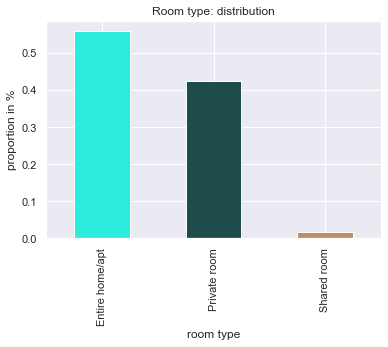

In [17]:
# bar chart: room type distribution
colors_room_type = myu.generate_random_colorlist(3)
(munich_listings["room_type"].value_counts()/munich_listings.shape[0]).plot(kind="bar", color=colors_room_type)
plt.title("Room type: distribution");
plt.xlabel("room type");
plt.ylabel("proportion in %");

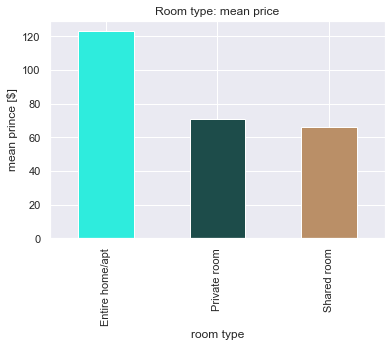

In [18]:
# bar chart: room type mean prices
(munich_listings.groupby("room_type").mean()["price"]).plot(kind="bar", color=colors_room_type);
plt.title("Room type: mean price");
plt.xlabel("room type");
plt.ylabel("mean prince [$]");

##### Neighbourhood / district

In [98]:
munich_lat = munich_listungs["latitude"].mean()
munich_long = munich_listungs["longitude"].mean()
munich_neighbourhoods = "./data/munich/neighbourhoods.geojson"
munich_price = munich_listings.groupby(by="neighbourhood").mean().reset_index()

munich_map = folium.Map(location=[munich_lat, munich_long], zoom_start=11, tiles="Stamen Toner")
folium.Choropleth(
    geo_data=munich_neighbourhoods,
    name='choropleth',
    data=munich_price,
    columns=['neighbourhood', 'price'],
    #key_on='feature.properties.name',
    key_on='feature.properties.neighbourhood',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend = "Mean Price (Euro)"
).add_to(munich_map)

folium.LayerControl().add_to(munich_map)

munich_map

In [99]:
folium.CircleMarker(
    location=[48.13084068072524, 11.550180677497941],
    radius=15,
    popup="Oktoberfest",
    color="#ff0000",
    fill=True,
    fill_color="#3186cc",
).add_to(munich_map)
munich_map

In [111]:
folium.map.Marker(
    [48.13084068072524, 11.550180677497941],
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-size: 24pt">Oktoberfest</div>',
        )
    ).add_to(munich_map)
munich_map

In [19]:
# get unique neighbourhoods / districts
neighbourhoods = munich_listings["neighbourhood"].unique()
print("There are", len(neighbourhoods), "unique neighbourhoods/districts with AirBnb listings in Munich:")
for neighbourhood in neighbourhoods:
    print("*", neighbourhood)

There are 25 unique neighbourhoods/districts with AirBnb listings in Munich:
* Ludwigsvorstadt-Isarvorstadt
* Hadern
* Berg am Laim
* Maxvorstadt
* Pasing-Obermenzing
* Sendling-Westpark
* Untergiesing-Harlaching
* Schwabing-West
* Bogenhausen
* Au-Haidhausen
* Neuhausen-Nymphenburg
* Schwanthalerhöhe
* Tudering-Riem
* Sendling
* Schwabing-Freimann
* Ramersdorf-Perlach
* Feldmoching-Hasenbergl
* Thalkirchen-Obersendling-Forstenried-Fürstenried-Solln
* Milbertshofen-Am Hart
* Obergiesing
* Altstadt-Lehel
* Laim
* Aubing-Lochhausen-Langwied
* Moosach
* Allach-Untermenzing


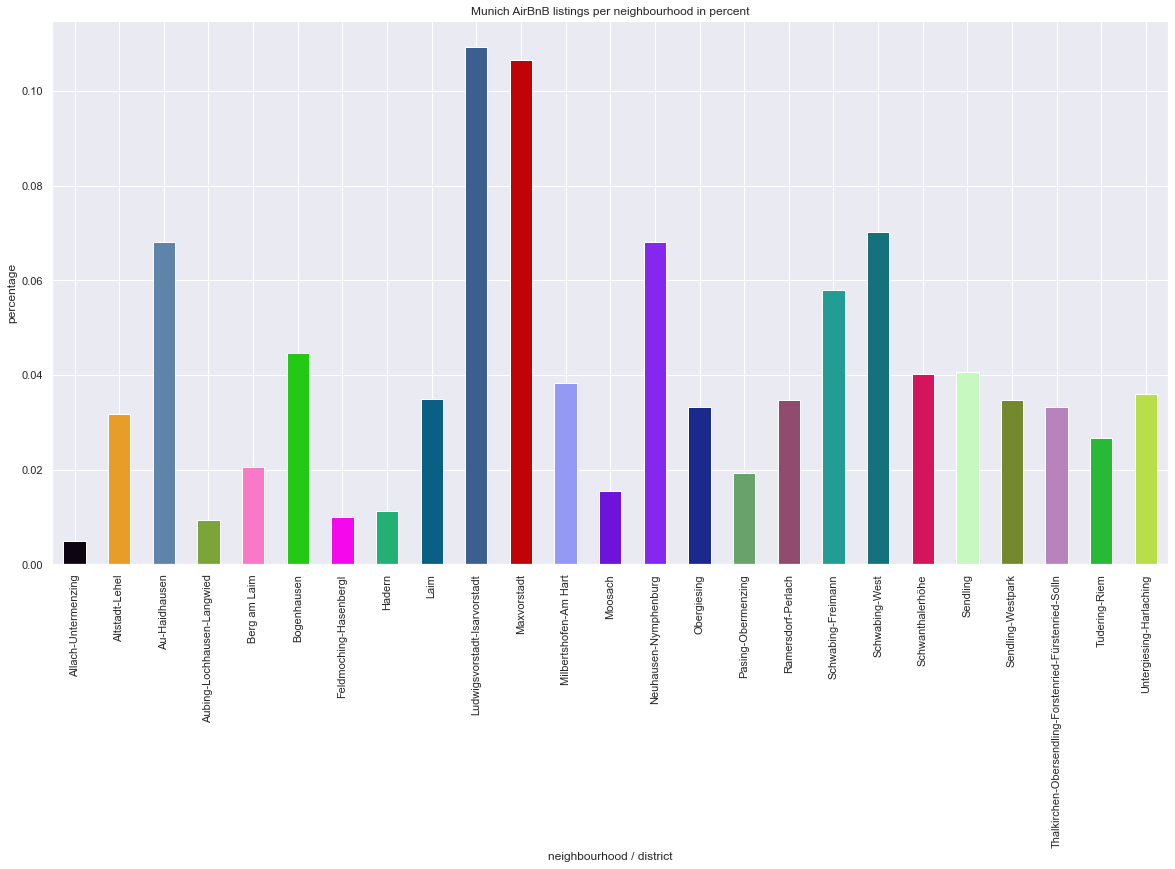

In [21]:
neighbourhood_vals = munich_listings["neighbourhood"].value_counts().sort_index() 
# bar chart: listings in neighbourhoods/districts
colors_neighbourhood = myu.generate_random_colorlist(len(neighbourhood_vals))
(neighbourhood_vals/munich_listings.shape[0]).plot(kind="bar", figsize=(20,10), color=colors_neighbourhood);
plt.title("Munich AirBnB listings per neighbourhood in percent");
plt.ylabel("percentage");
plt.xlabel("neighbourhood / district");

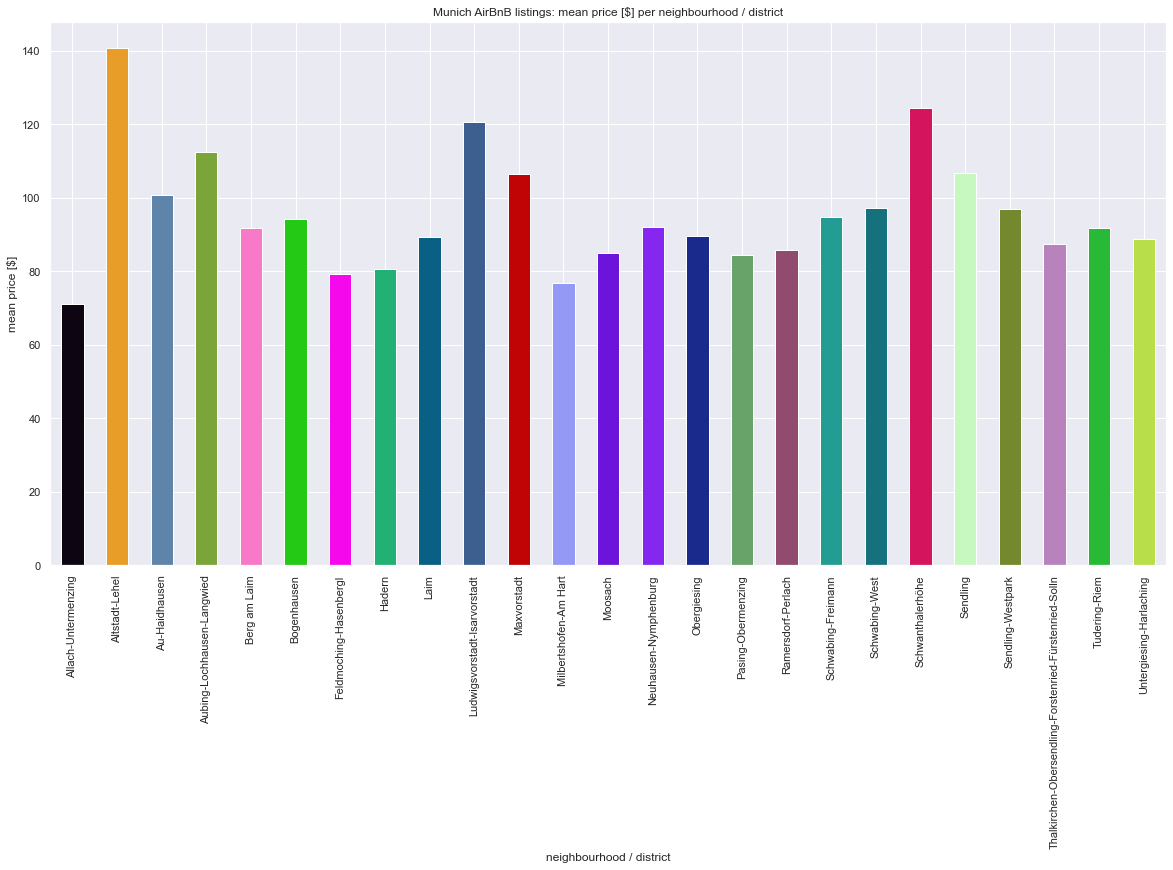

In [22]:
price_vals = munich_listings.groupby("neighbourhood").mean()["price"].sort_index()
# bar chart: mean price of AirBnB listings in Munich's districts
(price_vals).plot(kind="bar", figsize=(20,10), color=colors_neighbourhood);
plt.title("Munich AirBnB listings: mean price [$] per neighbourhood / district");
plt.ylabel("mean price [$]");
plt.xlabel("neighbourhood / district");

#### Reviews

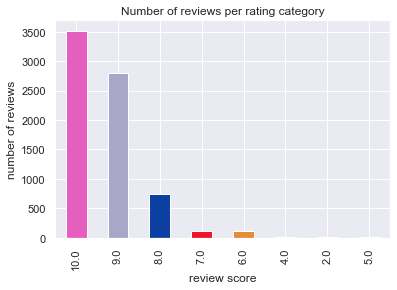

In [23]:
#munich_listings.groupby("number_of_reviews").mean()
#munich_listings.groupby("review_scores_value").value_counts()
colors_review = myu.generate_random_colorlist(10)
(munich_listings["review_scores_value"].value_counts()).plot(kind="bar", color=colors_review);
plt.title("Number of reviews per rating category");
plt.xlabel("review score");
plt.ylabel("number of reviews");

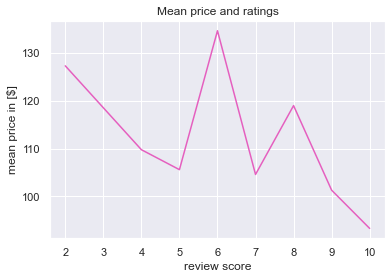

In [24]:
(munich_listings.groupby("review_scores_value").mean())["price"].plot(color=colors_review);
plt.title("Mean price and ratings");
plt.xlabel("review score");
plt.ylabel("mean price in [$]");

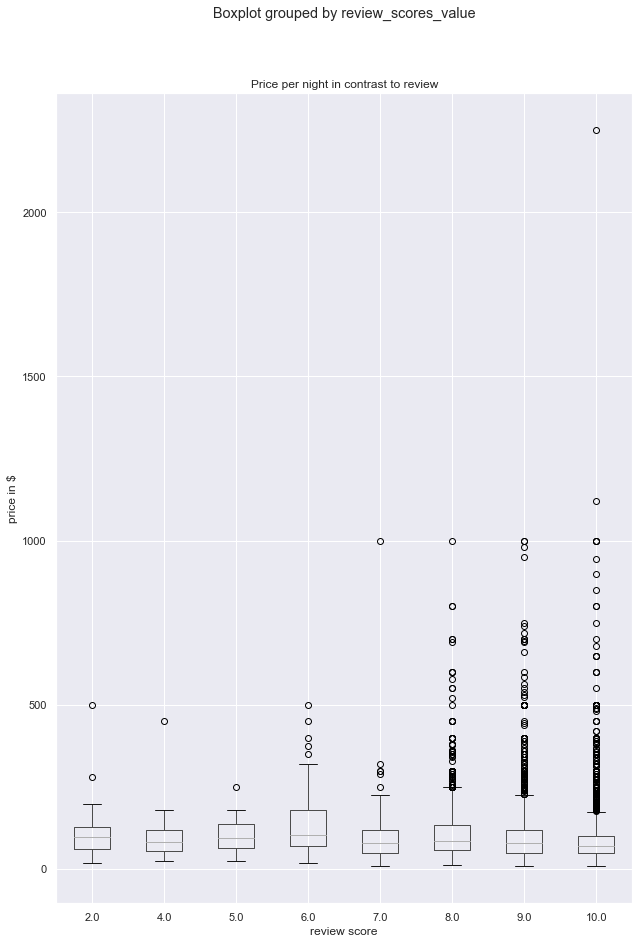

In [25]:
#(munich_listings.groupby("review_scores_value").mean()).plot.box(column="price")
munich_listings.boxplot(column=["price"], by=["review_scores_value"], figsize = (10,15));
plt.title("Price per night in contrast to review");
plt.xlabel("review score");
plt.ylabel("price in $");

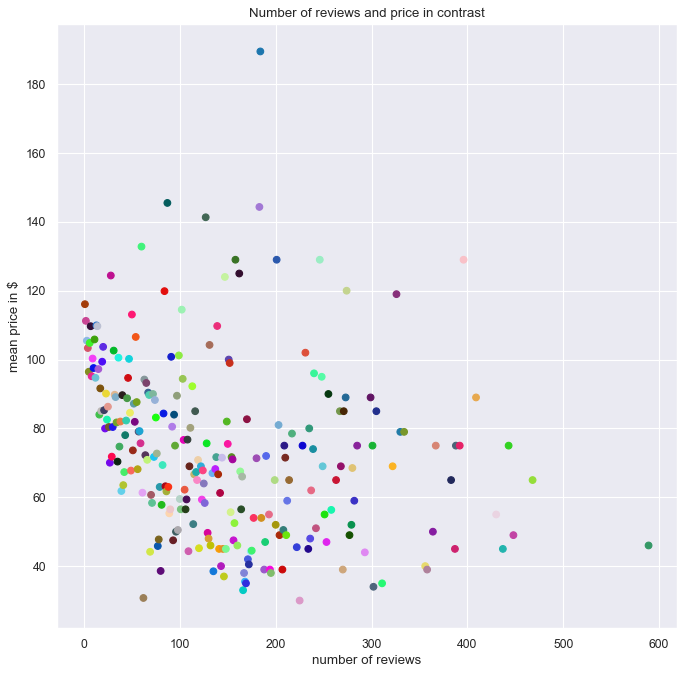

In [27]:
reviews = munich_listings.groupby("number_of_reviews").mean()["price"]
plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(reviews.index, reviews, color=myu.generate_random_colorlist(len(reviews)));
plt.title("Number of reviews and price in contrast");
plt.xlabel("number of reviews");
plt.ylabel("mean price in $");

##### Host specific data: Superhost

In [28]:
munich_listings.groupby("host_is_superhost").describe()["price"]

,count,mean,std,min,25%,50%,75%,max
host_is_superhost,,,,,,,,
f,6125.0,102.872653,96.280979,8.0,50.0,79.0,119.0,2250.0
t,1201.0,84.646961,67.184239,17.0,45.0,65.0,99.0,945.0


#### Host specific data: host_identity_verified

In [29]:
munich_listings.groupby("host_identity_verified").describe()["price"]

,count,mean,std,min,25%,50%,75%,max
host_identity_verified,,,,,,,,
f,4596.0,99.599869,88.777786,8.0,50.0,77.0,115.0,1120.0
t,2730.0,100.364469,98.175329,14.0,50.0,75.0,110.0,2250.0


#### Host specific data: instant_bookable

In [30]:
munich_listings.groupby("instant_bookable").describe()["price"]

,count,mean,std,min,25%,50%,75%,max
instant_bookable,,,,,,,,
f,5223.0,97.549684,89.408102,10.0,50.0,75.0,110.0,2250.0
t,2103.0,105.684261,99.180209,8.0,50.0,79.0,120.0,1120.0


### 1.5 Linear Model for price prediction

### 2. Reviews
 Is there any connection between price and rating (are the more expensiver offers better reviewd?)
 which was mentioned at most in good ratings?!

In [ ]:
#berlin_listings = pd.read_csv("./data/berlin/listings.csv.gz")
#berlin_calendar = pd.read_csv("./data/berlin/calendar.csv.gz")
#berlin_reviews = pd.read_csv("./data/berlin/reviews.csv.gz")

### 3. Influence of events during the year, e.g. Oktoberfest
 - problem: only prices from the future, the real bookings are not available
 - check data from march against data from spetember and october and check number of available offers, price, availability
 
 

In [ ]:
#munich_calendar_raw = pd.read_csv("./data/munich/calendar.csv.gz")

# join listungs with calendar

